# Importing Libraries


In [45]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Stock Selection

In [46]:
start = '2017-06-01' #START DATE
end = '2020-06-01'  #END DATE

name_stock1 = "EICHERMOT.NS"
name_stock2 = "MOTHERSON.NS"

stock1 = yf.Ticker(name_stock1)
stock2 = yf.Ticker(name_stock2)

#USING THE DATASET OF DAILY STOCK PRICES
stock1_data = stock1.history(interval = '1d' , start = start , end = end)
stock2_data = stock2.history(interval = '1d' , start = start , end = end)

In [47]:
print(stock1_data.shape)
stock1_data.head()

(735, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-01 00:00:00+05:30,2698.339127,2739.829224,2690.786043,2718.487061,474760,0.0,0.0
2017-06-02 00:00:00+05:30,2735.160288,2766.316756,2728.551340,2754.996582,299540,0.0,0.0
2017-06-05 00:00:00+05:30,2752.263066,2774.341680,2752.263066,2768.724121,168290,0.0,0.0
2017-06-06 00:00:00+05:30,2766.788828,2774.691352,2737.992698,2756.044678,169780,0.0,0.0
2017-06-07 00:00:00+05:30,2756.488505,2811.234070,2756.488505,2805.328613,465870,0.0,0.0


In [48]:
print(stock2_data.shape)
stock2_data.head()

(735, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-06-01 00:00:00+05:30,74.670042,75.350070,74.205637,74.346619,7992818,0.0,0.0
2017-06-02 00:00:00+05:30,74.437856,75.947181,74.338336,75.350082,8557902,0.0,0.0
2017-06-05 00:00:00+05:30,75.358376,75.963762,75.233978,75.416428,3376939,0.0,0.0
2017-06-06 00:00:00+05:30,75.466172,76.909150,75.092985,75.913994,13369082,0.0,0.0
2017-06-07 00:00:00+05:30,75.897413,76.793057,75.491060,76.477928,5847598,0.0,0.0


# Plots for Closing Prices of the Stocks


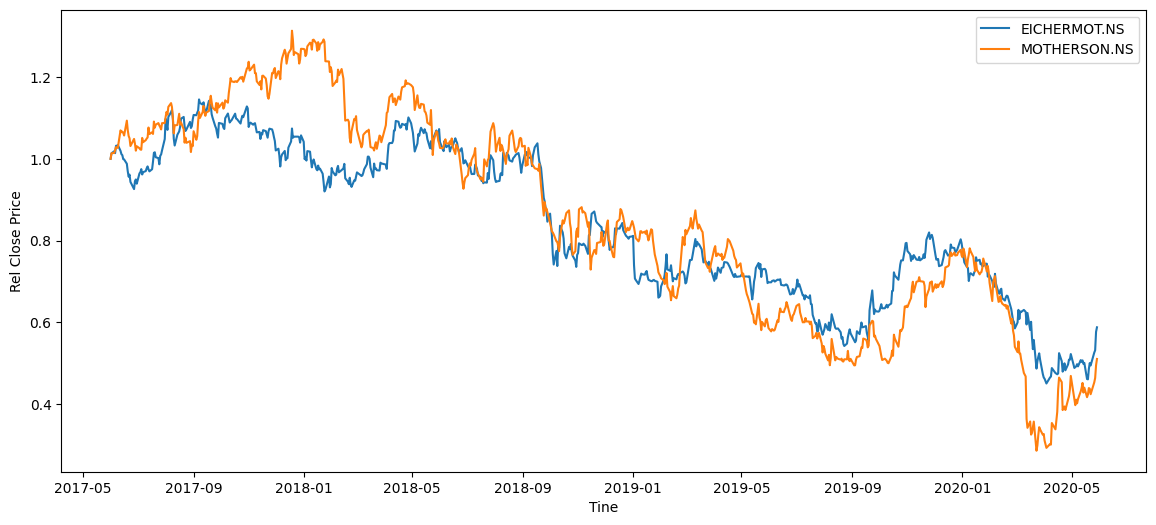

In [49]:
plt.figure(figsize=(14, 6))
stock1_close_relative = stock1_data["Close"] / stock1_data["Close"][0]
stock2_close_relative = stock2_data["Close"]/ stock2_data["Close"][0]
plt.plot(stock1_close_relative , label = name_stock1 )
plt.plot(stock2_close_relative , label = name_stock2 )
plt.xlabel("Tine")
plt.ylabel("Rel Close Price")
plt.legend()
plt.show()

# Plots for Relative Closing Prices of the Stocks


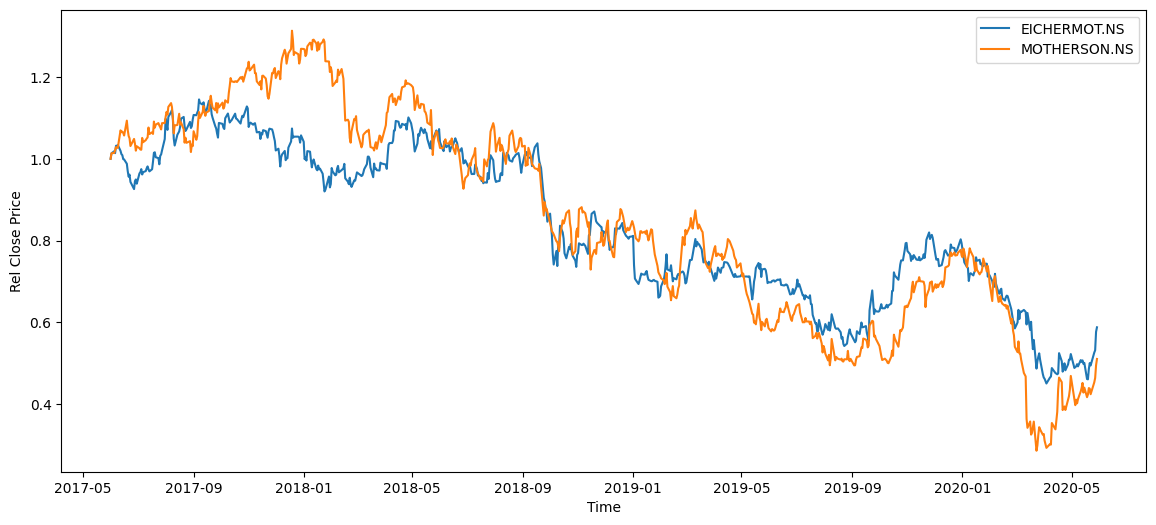

In [50]:
plt.figure(figsize=(14, 6))
stock1_close_relative = stock1_data["Close"] / stock1_data["Close"][0]
stock2_close_relative = stock2_data["Close"]/ stock2_data["Close"][0]
plt.plot(stock1_close_relative , label = name_stock1 )
plt.plot(stock2_close_relative , label = name_stock2 )
plt.xlabel("Time")
plt.ylabel("Rel Close Price")
plt.legend()
plt.show()

# p-value for the selected pair

In [51]:
# prints the p value for the null hypothesis
from statsmodels.tsa.stattools import coint, adfuller
coint_result = coint(stock2_data["Close"],stock1_data["Close"])
print(coint_result[1])

0.0040807622125399205


# Performing Linear Regressing using OLS

In [52]:
Y = np.log(stock2_data["Close"]) #TAKING LOGARITHM OF THE CLOSE PRICE OF STOCK 2
X = np.log(stock1_data["Close"]) #TAKING LOGARITHM OF THE CLOSE PRICE OF STOCK 1
X = sm.add_constant(X)  #ADDING A CONSTANT WHICH IS THE INTERCEPT
model = sm.OLS(Y,X)  #FITTING THE LINEAR REGRESSING MODEL
results = model.fit()
results.params

beta = results.params.values[1]  #EXTRACTS THE SLOPE OF THE LR
errors = Y - (X["Close"]*beta)

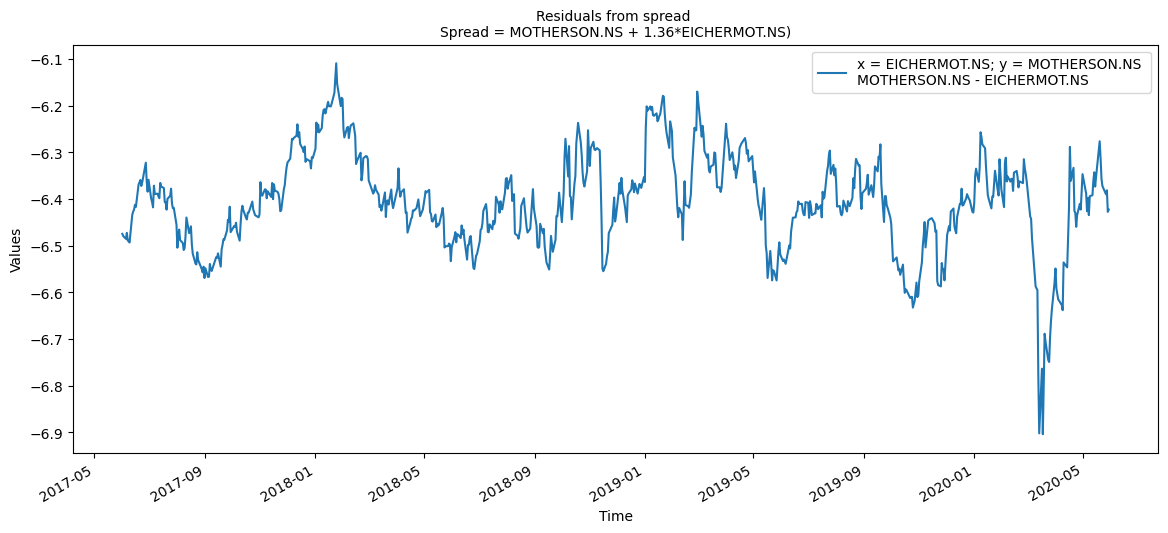

In [53]:
plt.figure(figsize=(14, 6))

errors.plot(label=f"x = {name_stock1}; y = {name_stock2} \n{name_stock2} - {name_stock1}")
plt.title(f'Residuals from spread \nSpread = {name_stock2} + {beta:.2f}*{name_stock1})', fontsize=10)
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


# Calculating the Z-Score

In [54]:
spread = errors
zscore = (spread-np.mean(spread)) / np.std(spread)

# Plotting the Z-Score

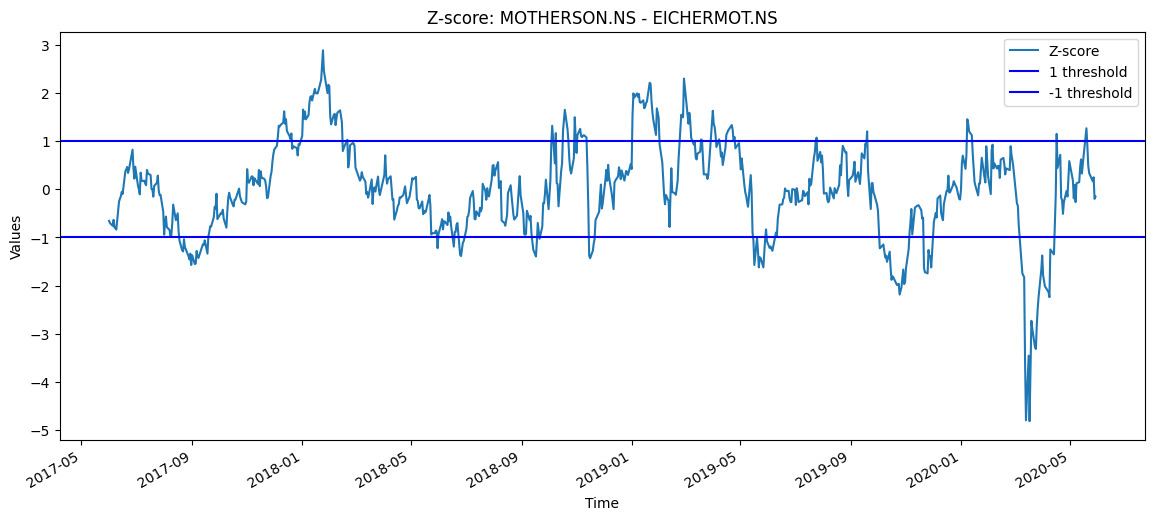

In [55]:
plt.figure(figsize=(14, 6))
zscore.plot(label='Z-score')
plt.title(f"Z-score: {name_stock2} - {name_stock1}")
plt.xlabel("Time")
plt.ylabel("Values")
plt.axhline(y=1, color='b', label='1 threshold')
plt.axhline(y=-1, color='b', label='-1 threshold')
plt.legend()
plt.show()


# Backtesting

**Generating Signals**

In [56]:
def generate_trade_signals(S1, S2, spread,zscore):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [-1, 1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()
  for i in range(len(signals["position1"])):
    if(signals["position1"][i]>1 or signals["position1"][i]<-1 ):
      signals["position1"][i]=0
    if(signals["position2"][i]>1 or signals["position2"][i]<-1 ):
      signals["position2"][i]=0
  return signals

In [57]:
trade_signals = generate_trade_signals(stock2_data["Close"],stock1_data["Close"] ,spread,zscore)
trade_signals.dropna(inplace = True)
print(trade_signals.shape)
trade_signals.head()

(734, 8)


,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2017-06-02 00:00:00+05:30,75.350082,2754.996582,-6.479501,-0.700823,0,0.0,0,0.0
2017-06-05 00:00:00+05:30,75.416428,2768.724121,-6.485399,-0.757952,0,0.0,0,0.0
2017-06-06 00:00:00+05:30,75.913994,2756.044678,-6.472564,-0.633623,0,0.0,0,0.0
2017-06-07 00:00:00+05:30,76.477928,2805.328613,-6.489332,-0.796051,0,0.0,0,0.0
2017-06-08 00:00:00+05:30,76.345238,2803.237305,-6.490052,-0.803021,0,0.0,0,0.0


**Plot for the Long & Short Posiitons**

In [58]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  plt.title(f'{name_stock2} / {name_stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

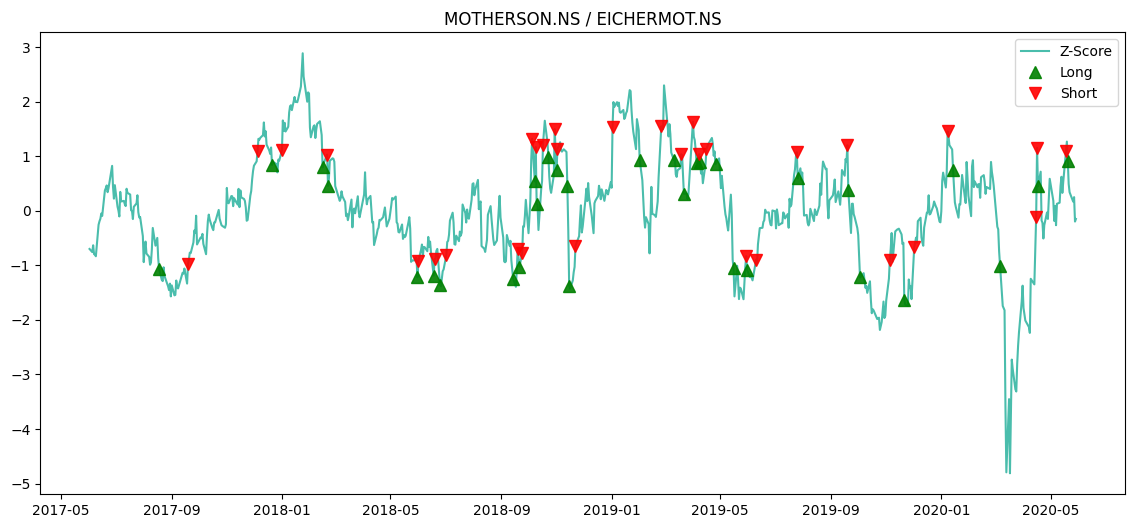

In [59]:
plot_pair_trades(trade_signals)

**PnL Calculation**

In [60]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [61]:
portfolio = pnl_calculation(trade_signals)
print(portfolio.shape)
portfolio.head()

(733, 9)


,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2017-06-05 00:00:00+05:30,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2017-06-06 00:00:00+05:30,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2017-06-07 00:00:00+05:30,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2017-06-08 00:00:00+05:30,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0
2017-06-09 00:00:00+05:30,0.0,50000.0,50000.0,0.0,0.0,50000.0,50000.0,0.0,100000.0


# Portfolio Curve

In [62]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

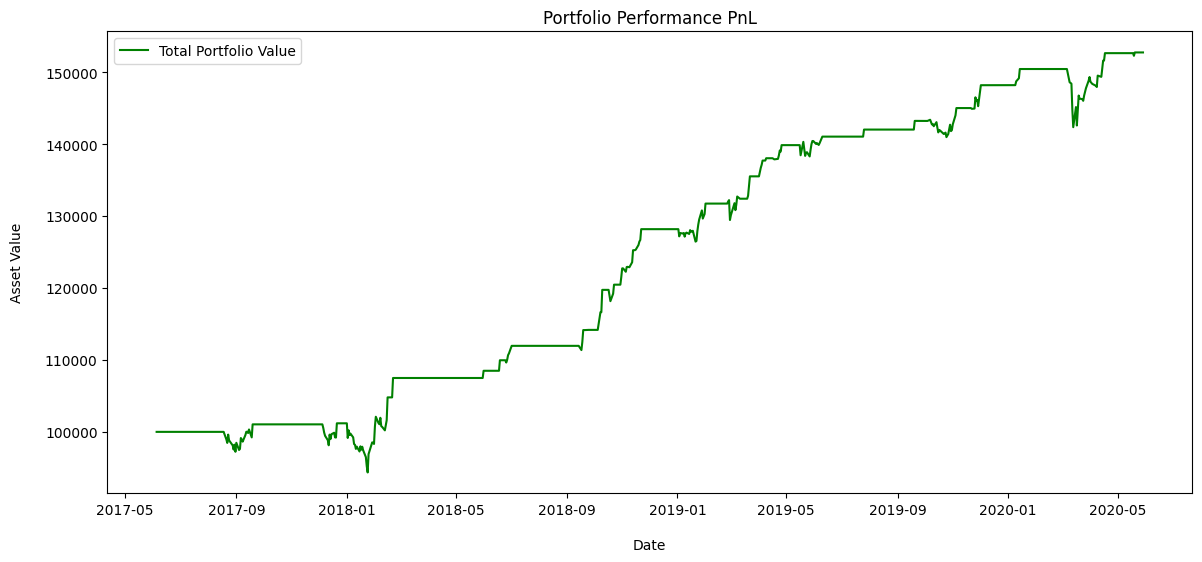

In [63]:
plot_portfolio_value(portfolio)